In [148]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### Raw data location

In [2]:
# Location of data
folder_raw='../../data/raw/QALY_model/postponement_non_covid_care/UZG/'
# Data name
name_raw_list=['MZG_2017.xlsx','MZG_2018.xlsx', 'MZG_2019.xlsx', 'MZG_2020.xlsx', 'MZG_2021_sem1.xlsx']
path_list=[]
for idx,name in enumerate(name_raw_list):
    path_list.append(os.path.join(folder_raw,name))

### Results location

In [3]:
# Location of results
folder_interim='../../data/interim/QALY_model/postponement_non_covid_care/UZG/'
# Name of results
name_interim='MZG_2017_2021.xlsx'

### Load datasets and merge them

In [4]:
df = pd.concat(
    map(pd.read_excel, path_list))

### Format data

In [5]:
# Throw out names of MDC (can look this up online)
del df['Pathologie - APR-MDC naam']
del df['Pathologie - APR-MDC naam (en)']
df.rename(columns={'Pathologie - APR-MDC sleutel': 'APR_MDC_key',
                   'MZG Opnamedatum - tekst': 'intake_date',
                   'MZG Ontslagdatum - tekst': 'discharge_date',
                   'Bezoek Opnameleeftijd per 5': 'age_group',
                   'Verblijf type - label': 'stay_type'}, inplace=True)
# Remove missing discharge dates
print('Removed {0}/{1} entries due to missing discharge date'.format(len(df['discharge_date'][df['discharge_date']=='No Date']), len(df)))
df = df[df.discharge_date != 'No Date']
# Parse dates
df['intake_date'] = pd.to_datetime(df.intake_date, format='%d/%m/%Y')
df['discharge_date'] = pd.to_datetime(df.discharge_date, format='%d/%m/%Y')
# Replace stay types with their key
mapping = {'H | Klassieke hospitalisatie': 'H',
           'D | Andere daghospitalisatie': 'D',
           'C | Chirurgisch dagziekenhuis': 'C',
           'M | Tussentijdse registratie langdurig verblijf': 'M',
           'F | Eerste registratie langdurig verblijf': 'F',
           'L | Laatste registratie langdurig verblijf': 'L'}
df.stay_type=df.stay_type.map(lambda x: mapping.get(x) if x else None)
# Throw out categories M, F, L
print("Removed {0}/{1} entries with stay_type 'M'".format(len(df['stay_type'][df['stay_type']=='M']), len(df)))
print("Removed {0}/{1} entries with stay_type 'F'".format(len(df['stay_type'][df['stay_type']=='F']), len(df)))
print("Removed {0}/{1} entries with stay_type 'L'".format(len(df['stay_type'][df['stay_type']=='L']), len(df)))
df = df[( (df.stay_type != 'L') & (df.stay_type != 'F') & (df.stay_type != 'M'))]
# Replace age categories with a simpler format
mapping={'Cat: 0 - 4': '0-4', 'Cat: 5 - 9': '5-9', 'Cat: 10 - 14': '10-14', 'Cat: 15 - 19': '15-19',
         'Cat: 20 - 24': '20-24', 'Cat: 25 - 29': '25-29', 'Cat: 30 - 34': '30-34', 'Cat: 35 - 39': '35-39',
         'Cat: 40 - 44': '40-44', 'Cat: 45 - 49': '45-49', 'Cat: 50 - 54': '50-54', 'Cat: 55 - 59': '55-59',
         'Cat: 60 - 64': '60-64', 'Cat: 65 - 69': '65-69', 'Cat: 70 - 74': '70-74', 'Cat: 75 - 79': '75-79',
         'Cat: 80 - 84': '80-84', 'Cat: 85 - 89': '85-89', 'Cat: 90 - 94': '90-94', 'Cat: 95+': '95-120'}
df.age_group=df.age_group.map(lambda x: mapping.get(x) if x else None)
# Throw out missing APR-MDC classifications
print("Removed {0}/{1} entries because APR-MDC classification was missing".format(len(df.APR_MDC_key[df.APR_MDC_key=='.']), len(df)))
df = df[df.APR_MDC_key!='.']
# Index on intake_date and sort
df = df.set_index(['APR_MDC_key', 'age_group', 'stay_type']).sort_index()
# Save lowest and highest intake date
intake_min = df.intake_date.min()
intake_max = df.intake_date.max()

Removed 164/427269 entries due to missing discharge date
Removed 0/427105 entries with stay_type 'M'
Removed 0/427105 entries with stay_type 'F'
Removed 136/427105 entries with stay_type 'L'
Removed 41392/426969 entries because APR-MDC classification was missing


In [6]:
dates = pd.date_range(start=intake_min, end=intake_max)
# Make a dataframe with desired output format
iterables=[]
for index_name in df.index.names:
    iterables += [df.index.get_level_values(index_name).unique()]
iterables.append(dates)
names=list(df.index.names)
names.append('date')
index = pd.MultiIndex.from_product(iterables, names=names)
target_df = pd.Series(index=index, name='n_patients', data=np.zeros(len(index), dtype=int))

In [7]:
with tqdm(total=len(df.index.get_level_values('APR_MDC_key').unique())*len(df.index.get_level_values('age_group').unique())) as pbar:
    for APR_MDC_key in df.index.get_level_values('APR_MDC_key').unique():
        for age_group in df.index.get_level_values('age_group').unique():
            for stay_type in df.index.get_level_values('stay_type').unique():
                # Extract series (Use try/except structure to skip over missing entries)
                try:
                    data = df.loc[(APR_MDC_key, age_group, stay_type),:]
                    # Loop over every entry
                    for i in range(len(data)):
                        # Generate daterange from intake and discharge date
                        date_range = pd.date_range(start=data['intake_date'].iloc[i], end=data['discharge_date'].iloc[i])
                        # Add 1 in target dataframe between intake and discharge date
                        target_df.loc[APR_MDC_key, age_group, stay_type, date_range] += 1
                        
                except:
                    pass
            pbar.update(1)
            
        #grpby.loc[APR_MDC_key, slice(None)].plot()

100%|███████████████████████████████████████| 560/560 [8:43:58<00:00, 56.14s/it]


### Save result

In [8]:
target_df.to_csv(os.path.join(folder_interim, name_interim))

## -------------------------
## Skip all the above 
## -------------------------

### Load result

In [121]:
df = pd.read_csv(os.path.join(folder_interim, name_interim), index_col=[0,1,2,3], parse_dates=True)
df.head()

n_patients
APR_MDC_key age_group stay_type date                  
00          0-4       C         2016-07-04           0
                                2016-07-05           0
                                2016-07-06           0
                                2016-07-07           0
                                2016-07-08           0

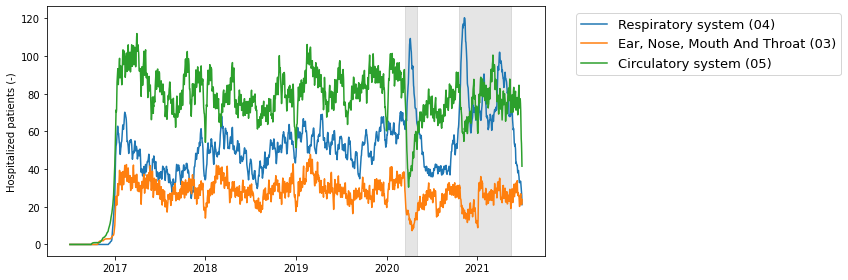

In [236]:
APR_MDC_keys=['04', '03', '05']
labels=['Respiratory system (04)', 'Ear, Nose, Mouth And Throat (03)', 'Circulatory system (05)']
filter_length=7


fig,ax=plt.subplots(figsize=(12,4))
ax.grid(False)
for APR_MDC_key in APR_MDC_keys:
    d = df.groupby(by=['APR_MDC_key','date']).sum().loc[APR_MDC_key, slice(None)].ewm(span=filter_length).mean()
    ax.plot(d)
ax.axvspan(pd.Timestamp('2020-03-15'),pd.Timestamp('2020-05-01'), color='black', alpha=0.1)
ax.axvspan(pd.Timestamp('2020-10-19'),pd.Timestamp('2021-05-15'), color='black', alpha=0.1)
ax.set_ylabel('Hospitalized patients (-)')
ax.legend(labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)
plt.tight_layout()
plt.show()
plt.close()
fig.savefig('postponement_nonCOVID_care.jpg', dpi=600)

### Convert date to day-of-year number for the entire dataset

In [170]:
# Define a target dataframe containing the day-of-year number instead of the date
day_of_year = np.linspace(1,365,num=364+1, dtype=int)
iterables=[]
names=[]
for index_name in df.index.names:
    if index_name != 'date':
        iterables += [df.index.get_level_values(index_name).unique()]
        names += [index_name,]
iterables.append(day_of_year)
names.append('day_of_year')
index = pd.MultiIndex.from_product(iterables, names=names)
baseline_df = pd.Series(index=index, name='n_patients', data=np.zeros(len(index), dtype=int))

In [172]:
# Use all data from the second week of 2017 until beginning of 2020 as baseline
baseline = df[((df.index.get_level_values('date')<pd.Timestamp('2020-01-01'))&(df.index.get_level_values('date')>=pd.Timestamp('2017-02-01')))]

In [173]:
# Loop over all possible indices, convert date to day of year, take average of values with same day-of-year number
with tqdm(total=len(baseline.index.get_level_values('APR_MDC_key').unique())*len(baseline.index.get_level_values('age_group').unique())) as pbar:
    for APR_MDC_key in baseline.index.get_level_values('APR_MDC_key').unique():
        for age_group in baseline.index.get_level_values('age_group').unique():
            for stay_type in baseline.index.get_level_values('stay_type').unique():
                # Extract dataseries
                data = baseline.loc[(APR_MDC_key, age_group, stay_type),:]
                # Reset index to 'unlock' the date
                data.reset_index(inplace=True)
                # Convert the date to a daynumber
                data['date'] = data['date'].apply(lambda x: x.day_of_year).values
                # In a leap year, the method returns 366 days (and we'll simply throw it out since 2016 will not be in the final baseline)
                data['date'] = data['date'][data['date']!=366]
                # Perform a groupby 'date' operation with mean() to take the mean of all values with similar daynumber
                baseline_df.loc[APR_MDC_key, age_group, stay_type, slice(None)] = data.groupby(by='date').mean().values.flatten()
            pbar.update(1)

100%|█████████████████████████████████████████| 560/560 [01:20<00:00,  6.93it/s]


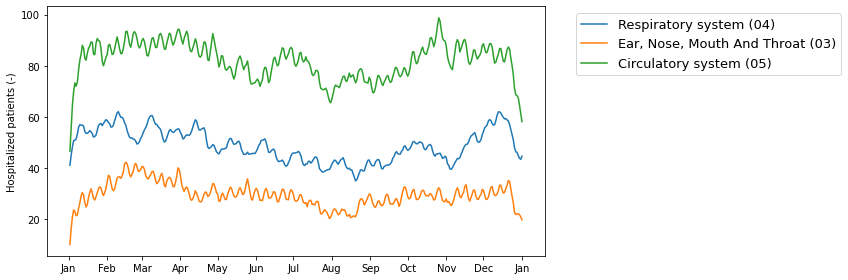

In [235]:
APR_MDC_keys=['04', '03', '05']
labels=['Respiratory system (04)', 'Ear, Nose, Mouth And Throat (03)', 'Circulatory system (05)']
filter_length=7


fig,ax=plt.subplots(figsize=(12,4))
ax.grid(False)
for APR_MDC_key in APR_MDC_keys:
    d = baseline_df.groupby(by=['APR_MDC_key','day_of_year']).sum().loc[APR_MDC_key, slice(None)].ewm(span=filter_length).mean()
    ax.plot(d)
ax.set_ylabel('Hospitalized patients (-)')
ax.legend(labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)

plt.tight_layout()
plt.show()
plt.close()
fig.savefig('postponement_nonCOVID_care_baseline.jpg', dpi=600)

### Normalize data with the baseline

In [219]:
# Consider all data from the beginning of 2020 as the actual 'data'
data_df = df[df.index.get_level_values('date')>=pd.Timestamp('2020-01-01')]

In [220]:
# Initialize target dataframe
target_df = data_df
# Remove leap year extra day
tmp=target_df.reset_index()
tmp=tmp[tmp['date'] != '2020-02-29']
target_df=tmp.set_index(['APR_MDC_key','age_group','stay_type','date'])
# Add a column for versus_baseline
target_df.loc[(),'versus_baseline']=0

In [225]:
# Loop over all possible indices, convert date to day of year, take average of values with same day-of-year number
with tqdm(total=len(data_df.index.get_level_values('APR_MDC_key').unique())*len(data_df.index.get_level_values('age_group').unique())) as pbar:
    for APR_MDC_key in data_df.index.get_level_values('APR_MDC_key').unique():
        for age_group in data_df.index.get_level_values('age_group').unique():
            for stay_type in data_df.index.get_level_values('stay_type').unique():
                # Extract dataseries
                data = data_df.loc[(APR_MDC_key, age_group, stay_type),:]
                # Reset index to 'unlock' the date
                data.reset_index(inplace=True)
                # Convert the date to a daynumber
                data['date'] = data['date'].apply(lambda x: x.day_of_year).values
                # In a leap year, the method returns 366 days
                # Important: Check if year is a leap year, delete entry 60, subtract 1 from all entries above 60
                data = data[data['date']!=366]
                # Extract baseline
                baseline = baseline_df.loc[(APR_MDC_key, age_group, stay_type, slice(None))]
                # Perform computation
                tmp=np.zeros(len(data['date'].values))
                for idx,date in enumerate(data['date'].values):
                    if baseline[date] != 0:
                        tmp[idx] = data.iloc[idx]['n_patients']/baseline[date]
                    else:
                        tmp[idx] = 1
                # Assign result
                target_df.loc[(APR_MDC_key, age_group, stay_type, slice(None)), 'versus_baseline'] = tmp
            pbar.update(1)

100%|█████████████████████████████████████████| 560/560 [01:15<00:00,  7.40it/s]


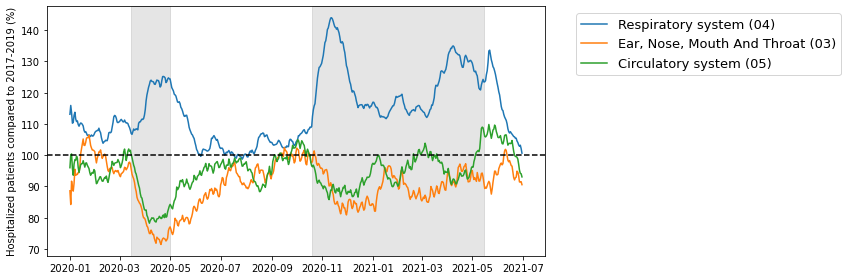

In [245]:
APR_MDC_keys=['04', '03', '05']
labels=['Respiratory system (04)', 'Ear, Nose, Mouth And Throat (03)', 'Circulatory system (05)']
filter_length=31

fig,ax=plt.subplots(figsize=(12,4))
ax.grid(False)
for APR_MDC_key in APR_MDC_keys:
    d = target_df['versus_baseline'].groupby(by=['APR_MDC_key','date']).mean().loc[APR_MDC_key, slice(None)].ewm(span=filter_length).mean()*100
    ax.plot(d)
ax.axvspan(pd.Timestamp('2020-03-15'),pd.Timestamp('2020-05-01'), color='black', alpha=0.1)
ax.axvspan(pd.Timestamp('2020-10-19'),pd.Timestamp('2021-05-15'), color='black', alpha=0.1)
ax.axhline(100, color='black', linestyle='--')
ax.set_ylabel('Hospitalized patients compared to 2017-2019 (%)')
ax.legend(labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)
plt.tight_layout()
plt.show()
plt.close()
fig.savefig('postponement_nonCOVID_care_versus_baseline_1.jpg', dpi=600)

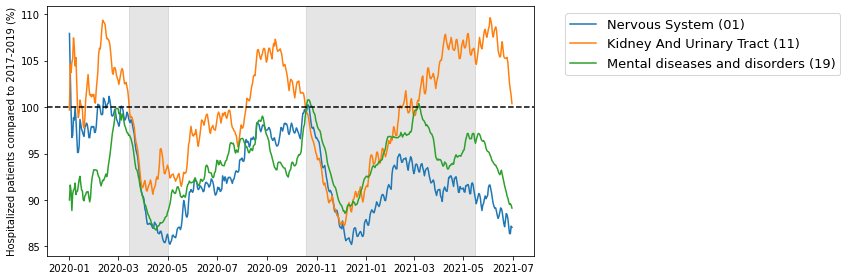

In [250]:
APR_MDC_keys=['01', '11', '19']
labels=['Nervous System (01)', 'Kidney And Urinary Tract (11)', 'Mental diseases and disorders (19)']
filter_length=62

fig,ax=plt.subplots(figsize=(12,4))
ax.grid(False)
for APR_MDC_key in APR_MDC_keys:
    d = target_df['versus_baseline'].groupby(by=['APR_MDC_key','date']).mean().loc[APR_MDC_key, slice(None)].ewm(span=filter_length).mean()*100
    ax.plot(d)
ax.axvspan(pd.Timestamp('2020-03-15'),pd.Timestamp('2020-05-01'), color='black', alpha=0.1)
ax.axvspan(pd.Timestamp('2020-10-19'),pd.Timestamp('2021-05-15'), color='black', alpha=0.1)
ax.axhline(100, color='black', linestyle='--')
ax.set_ylabel('Hospitalized patients compared to 2017-2019 (%)')
ax.legend(labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)
plt.tight_layout()
plt.show()
plt.close()
fig.savefig('postponement_nonCOVID_care_versus_baseline_2.jpg', dpi=600)